In [391]:
import json
from geopandas import GeoDataFrame
from shapely.geometry import Polygon, Point, LineString
import geopandas as gpd
import pandas as pd
from datetime import datetime
import re
import random
import os

import folium
from folium import PolyLine
from folium.plugins import MarkerCluster

#### Читаем данные и далее будет работать с 10% загруженных данных, выбранных случайным образом

In [392]:
n = 16353286 #number of records in file
percent_of_data_in_sample = 10.0
s = int(16353286./percent_of_data_in_sample) #desired sample size
filename = 'D:/registration.csv'
reg_cols = ['accepted_terms',
            'cascade_store',
            'code',
            'created_at',
            'email',
            'event',
            'external_id',
            'firstname',
            'id',
            'meta',
            'notify',
            'paid_at',
            'parent',
            'pay_till',
            'phone',
            'referrer',
            'registration_event_id',
            'registration_order',
            'status',
            'sum',
            'surname',
            'ticket_date',
            'ticket_date_id',
            'ticket_notify',
            'updated_at',
            'user']

use_reg_data_cols = [
                    #'id',
                    'user',
                    'registration_event_id',
                    'status',
                    'registration_order',
                    'sum',
                    'created_at',
                    'updated_at'
                    ]

skip = sorted(random.sample(range(n),n-s))
reg_data = pd.read_csv(filename, usecols = reg_cols, names = reg_cols, skiprows=skip)[use_reg_data_cols]

#### Считаем количество регистраций на события на всем наборе данных

In [492]:
path = "D:/data/registration"
file_list = os.listdir(path)
file_list[:5]

['registration_0.csv',
 'registration_1.csv',
 'registration_10.csv',
 'registration_100.csv',
 'registration_101.csv']

In [494]:
dict_event_count = Counter()
for file in file_list:
    curr_reg_data = pd.read_csv(path+'/'+file,usecols = ['user','registration_event_id'])
    
    event_count = curr_reg_data.groupby(['registration_event_id']).size().reset_index(name='counts')
    dict_event_count += Counter(dict(zip(list(event_count.registration_event_id.values), list(event_count.counts.values))))

In [495]:
reg_data['counts'] = reg_data['registration_event_id'].map(dict(dict_event_count))

In [499]:
sum(list(dict_event_count.values())) - n

0

In [512]:
numreg_events = pd.DataFrame.from_dict(dict_event_count, orient='index')#.reset_index('event_id')
numreg_events = numreg_events.reset_index()
numreg_events.columns = ['event_id','num_registrations']
numreg_events.to_csv('numreg_events.csv', index=False)

#### Сделаем свою собственную равномерную цветовую легенду количества регистраций на события

In [603]:
def get_ticks(data_list, num_of_partitions, min_quantile, max_quantile):
    min_v = data_list.quantile(min_quantile)
    max_v = data_list.quantile(max_quantile)
    data = [x for x in data_list if x>=min_v and x<=max_v]
    sort_list = list(sorted(data))
    ticks = []
    ticks.append(min(sort_list))
    
    for partition in range(num_of_partitions):
        ticks.append(max(sort_list[int(partition/num_of_partitions*len(sort_list)):int((partition+1)/num_of_partitions*len(sort_list))]))
    return ticks

In [604]:
ticks = get_ticks(numreg_events.num_registrations, 4, 0.05, 0.95)
ticks

[1, 2, 7, 22, 140]

In [633]:
# manual ticks in colormap
import branca.colormap as cm
from matplotlib import colors

def manual_legend(data_list, num_of_partitions, min_quantile, max_quantile):
    ticks = get_ticks(data_list, num_of_partitions, min_quantile, max_quantile)
    #print(ticks)
    return cm.StepColormap(list(colors.TABLEAU_COLORS.values())[:num_of_partitions], 
                           vmin=data_list.quantile(min_quantile,), 
                           vmax=data_list.quantile(max_quantile,), 
                           index=ticks, 
                           caption='step')

In [634]:
man_cmap = manual_legend(numreg_events.num_registrations, 5, 0.05, 0.95)

### Delete user's duplicates (we do not need users)

In [609]:
print(len(set(reg_data.registration_event_id)))

reg_data = reg_data.loc[:, ['registration_event_id', 'counts']]
reg_test = reg_data.drop_duplicates()

255252


In [610]:
reg_test.shape

(255252, 2)

In [611]:
reg_data.shape

(1635329, 2)

In [612]:
import branca.colormap as cm
from matplotlib import colors
#print(colors.TABLEAU_COLORS['tab:blue'])

cont_cmap = cm.LinearColormap([colors.TABLEAU_COLORS['tab:green'], 
                               colors.TABLEAU_COLORS['tab:orange'], 
                               colors.TABLEAU_COLORS['tab:red']],
                         vmin=reg_data['counts'].quantile(0), vmax=reg_data['counts'].quantile(1),
                         caption = '# of registrations')

cmap = cm.LinearColormap(['green', 'yellow', 'orange', 'red'])
cmap = cmap.to_step(
    n=400,
    data=reg_data['counts'],
    method='linear')
cmap.caption = "# of registrations"

In [613]:
cont_cmap

In [614]:
cmap

In [615]:
use_coords_cols = ['event_id', 
                   'place_lat', 
                   'place_lon', 
                   #'subw_lat', 
                   #'subw_lon',
                  ]
event_coords = pd.read_csv('event_coo.csv', usecols = use_coords_cols)
geometry = [Point(xy) for xy in zip(event_coords.place_lon, event_coords.place_lat)]
event_coords = GeoDataFrame(event_coords, geometry=geometry)
json_coords = json.loads(event_coords.to_json())['features']

In [616]:
json_coords[0]

{'geometry': {'coordinates': [0.6863939762115479, 47.39677047729492],
  'type': 'Point'},
 'id': '0',
 'properties': {'event_id': 409,
  'place_lat': 47.39677047729492,
  'place_lon': 0.6863939762115479},
 'type': 'Feature'}

In [617]:
reg_events = pd.merge(reg_test, event_coords, how='left', left_on='registration_event_id', right_on='event_id')
reg_events = reg_events.dropna(subset=['geometry'], how='all')

In [618]:
reg_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89126 entries, 31 to 255251
Data columns (total 6 columns):
registration_event_id    89126 non-null int64
counts                   89126 non-null int64
event_id                 89126 non-null float64
place_lat                89126 non-null float64
place_lon                89126 non-null float64
geometry                 89126 non-null object
dtypes: float64(3), int64(2), object(1)
memory usage: 4.8+ MB


In [619]:
#json_events = json.loads(reg_events.to_json())['features']

In [620]:
reg_events.shape

(89126, 6)

In [621]:
json_ids = []
event_ids = []
for id in range(len(json_coords)):
    json_ids.append(int(json_coords[id]['id']))
    event_ids.append(int(json_coords[id]['properties']['event_id']))
id_map_dict = dict(zip(event_ids,json_ids))

In [622]:
# color mapping

import matplotlib
import matplotlib.cm as cm

lst = [1.9378076554115014, 1.2084586588892861, 1.2133096565896173, 1.2427632053442292, 
       1.1809971732733273, 0.91960143581348919, 1.1106310149587162, 1.1106310149587162, 
       1.1527004351293346, 0.87318084435885079, 1.1666132876686799, 1.1666132876686799]

minima = min(lst)
maxima = max(lst)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.tab20c)
mapper.cmap.colors
#for v in lst:
#    print(mapper.to_rgba(v))

((0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.921568

In [623]:
reg_events.head()

,registration_event_id,counts,event_id,place_lat,place_lon,geometry
31,512,88,512.0,55.788952,37.707726,POINT (37.70772552490234 55.7889518737793)
34,541,27,541.0,63.564014,53.354935,POINT (53.35493469238281 63.56401443481445)
38,560,31,560.0,59.932468,30.349133,POINT (30.3491325378418 59.93246841430664)
40,569,15,569.0,55.753620,37.648853,POINT (37.64885330200195 55.75362014770508)
51,675,16,675.0,55.779327,37.670258,POINT (37.67025756835938 55.77932739257813)


In [624]:
from matplotlib import colors
print(colors.TABLEAU_COLORS)
#colors.
#color_dict = {reg_events.ix[p]['counts']:colors.to_hex(cm(reg_events.ix[p].color_group-.0001)) for p in reg_events.T}

OrderedDict([('tab:blue', '#1f77b4'), ('tab:orange', '#ff7f0e'), ('tab:green', '#2ca02c'), ('tab:red', '#d62728'), ('tab:purple', '#9467bd'), ('tab:brown', '#8c564b'), ('tab:pink', '#e377c2'), ('tab:gray', '#7f7f7f'), ('tab:olive', '#bcbd22'), ('tab:cyan', '#17becf')])


In [627]:
import branca.colormap as cm
cmap = cm.LinearColormap(['green', 'yellow', 'red'])
cmap = cmap.to_step(
    n=100,
    data=sorted(reg_events['counts'])[int(0.05*reg_events.shape[0]):int(0.95*reg_events.shape[0])],
    method='linear')
cmap.caption = "Количество регистраций на события"
cmap

In [628]:
cmap(1)

'#008000'

In [629]:
maxima = max(reg_events.counts.values)
print(min(sorted(reg_events.counts.values)[int(0.05*reg_events.shape[0]):]))
print(max(sorted(reg_events.counts.values)[:int(0.95*reg_events.shape[0])]))

2
217


[0, 2000, 0, 8500]

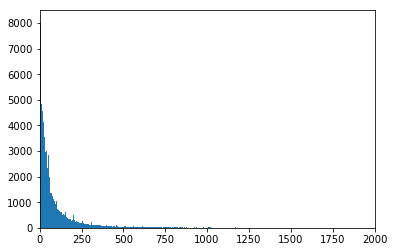

In [456]:
plt.hist(list(reg_events.counts.values), bins=10000)
plt.axis([0, 2000, 0, 8500])

In [635]:
this_map = folium.Map(location=[55.764414, 37.647859], zoom_start=10, prefer_canvas=True)
this_map.add_child(man_cmap)

In [636]:
for event_id in list(reg_events.registration_event_id.values)[:1000]:
    #name = re.sub('\W+',' ',event_moscow[event_moscow.id==event_id].name.values[0])
    #place = re.sub('\W+',' ',event_moscow[event_moscow.id==event_id].place.values[0])
    #city = re.sub('\W+',' ',event_moscow[event_moscow.id==event_id].city.values[0])
    #date = re.sub('\W+',' ',event_moscow[event_moscow.id==event_id].begin.values[0])
    #latitude = event_moscow[event_moscow.id==event_id].place_lon.values[0]
    #longitude = event_moscow[event_moscow.id==event_id].place_lat.values[0]
    count_regs = reg_events[reg_events.registration_event_id==event_id]['counts'].values[0]
    #print(city, place, date, name, latitude, longitude)
    event_description = folium.Html("""<b>Counts</b>: {}""".format(count_regs), script=True)
    
    popup = folium.Popup(event_description, max_width=2650)
    json_id = id_map_dict[event_id]

    folium.CircleMarker(list(reversed(json_coords[json_id]['geometry']['coordinates'])), 
                        popup=popup, 
                        color=cmap(reg_events[reg_events.registration_event_id==event_id]['counts'].values[0]),
                        radius=1 
                        #weight = 0
                 ).add_to(this_map)

In [637]:
this_map.save('reg_1000_030118.html')

### Folium/FloatImage

In [225]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from folium.plugins import FloatImage

fig = plt.figure(figsize=(4, .1))
ax = fig.add_axes([1, 1, 1, 1])
norm = colors.Normalize(0, 1)

#create a color map
my_colors = [(.4, .4, 1), (0, .9, 0) ,(1, .6, 0) , (1, 0, 0)] 
cm = colors.LinearSegmentedColormap.from_list("MyMap", my_colors, N=4)

leg = mpl.colorbar.ColorbarBase(ax, cmap=cm,
                                norm=norm,
                                orientation='horizontal')
leg.set_ticks([q/4 for q in range(5)])
leg.set_ticklabels([reg_data['counts'].quantile(q/4) for q in range(5)])

fig.text(1.5, 2, '# of registrations',
        horizontalalignment='center',
        verticalalignment='bottom')

fig.savefig(str('quartiles_legend.png'), bbox_inches='tight',transparent=True)
plt.close(fig)
FloatImage(str('quartiles_legend.png'),bottom=93, left=75).add_to(this_map)

#### Выделим ссылку на событие из датасета по событиям

In [639]:
events = pd.read_csv('D:/event.csv')
events.head()

C:\Users\PDudukin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,allow_multireg,begin,blocked,cascade_store,city,contact,created_at,culture,description,enable_comments,...,organization,parent,place,private,reglimit,shortdescription,status,twitter_keywords,updated_at,use_urpayments
0,0,2013-04-03 12:00:00,0,"a:5:{s:18:""to_end_description"";s:340:""<p>Извин...",Каменец-Подольский,NaN,2013-01-09 13:15:53,ru,"<div class=""event_description"">\n<p>Запуск биз...",1,...,55,NaN,Место и адрес проведения уточняются.,0,0,NaN,ok,NaN,2013-08-19 09:28:23,1
1,1,2013-04-06 15:00:00,0,"a:6:{s:16:""template_version"";s:8:""20130322"";s:...",Москва,NaN,2013-03-22 18:50:09,ru,<p><strong>О лекции: </strong>Нейробиологам из...,1,...,14098,NaN,"ул. Большая Полянка, 65/74, стр. 1. FAQcafe",0,0,Фестиваль «Искусство науки 2013» приглашает Ва...,ok,NaN,2013-08-19 09:05:50,0
2,0,2013-04-13 12:00:00,0,"a:5:{s:18:""to_end_description"";s:340:""<p>Извин...",Полтава,NaN,2013-01-09 13:15:53,ru,"<div class=""event_description"">\n<p>Запуск биз...",1,...,55,NaN,Место и адрес проведения уточняются.,0,0,NaN,ok,NaN,2013-08-20 02:30:31,1
3,1,2013-03-30 00:00:00,0,"a:6:{s:16:""template_version"";s:8:""20130322"";s:...",Без города,NaN,2013-03-22 19:09:29,ru,"<p style=""border: 0px; border-collapse: collap...",1,...,6761,NaN,NaN,0,0,"""Самый ценный актив — время. Большинство людей...",ok,NaN,2013-08-20 12:57:37,0
4,1,2013-03-29 12:00:00,0,"a:6:{s:16:""template_version"";s:8:""20130320"";s:...",Москва,NaN,2013-03-20 18:08:47,ru,<p>Приглашаем к участию в нашем клубе заинтере...,1,...,13713,NaN,"ул.Сущевская, д.21, подъезд 2, 3 этаж, офис 2,...",0,0,"Мы просвещаем людей, дающих в долг и людей бер...",ok,NaN,2013-08-18 05:59:07,0


In [641]:
events.cascade_store[0]

'a:5:{s:18:"to_end_description";s:340:"<p>Извините, регистрация закрыта. Возможно, на событие уже зарегистрировалось слишком много человек, либо истек срок регистрации. Подробности Вы можете узнать у организаторов события.</p>";s:16:"to_register_text";s:781:"<p>Вы только что зарегистрировались на событие <a href="http://hse-inc.timepad.ru/event/%eventid%/" target="_blank">%eventname%</a> организации <a href="http://hse-inc.timepad.ru" style="color:#003366;" target="_blank">%orgname%</a>. Подтверждаем, что Ваша регистрация прошла успешно.</p>\n\n<p>За несколько дней до события с вами свяжутся организаторы и сообщат вам, в какой вы команде.&nbsp;</p>\n\n<p><strong>Информация о событии</strong><br />\nНазвание: %eventname%<br />\nДата и время: %eventbegin%<br />\nМесто проведения: %eventplace%</p>\n\n<p>&nbsp;</p>";s:20:"to_register_mailtext";s:938:"<p style="margin:0;"><font face="Arial, Helvetica, sans-serif">Вы только что зарегистрировались на событие <a href="http://hse-inc.timepad.ru

In [642]:
events.cascade_store[1]

'a:6:{s:16:"template_version";s:8:"20130322";s:18:"to_end_description";s:340:"<p>Извините, регистрация закрыта. Возможно, на событие уже зарегистрировалось слишком много человек, либо истек срок регистрации. Подробности Вы можете узнать у организаторов события.</p>";s:16:"to_register_text";s:860:"<p>Вы только что зарегистрировались на событие лекция Елизаветы Муратовой на тему &laquo;Фотокомпозиция, цветовосприятие и цветоформа&raquo;. Подтверждаем, что Ваша регистрация прошла успешно.</p>\n\n<p>&nbsp;</p>\n\n<p><strong>Информация о событии</strong><br />\nНазвание: &nbsp;лекция Елизаветы Муратовой на тему &laquo;Фотокомпозиция, цветовосприятие и цветоформа&raquo;&nbsp;<br />\nДата и время: <font face="Arial, Helvetica, sans-serif">06 апреля, 15.00</font>&nbsp;<br />\nМесто проведения: ул. Большая Полянка, 65/74, стр. 1, FAQcafe</p>\n\n<p>&nbsp;</p>";s:20:"to_register_mailtext";s:934:"<p style="margin:0;">Вы только что зарегистрировались на событие лекция Елизаветы Муратовой на тему &l

In [645]:
from bs4 import BeautifulSoup
import re

In [646]:
BeautifulSoup(events.loc[0,'cascade_store'],"lxml").get_text()

'a:5:{s:18:"to_end_description";s:340:"Извините, регистрация закрыта. Возможно, на событие уже зарегистрировалось слишком много человек, либо истек срок регистрации. Подробности Вы можете узнать у организаторов события.";s:16:"to_register_text";s:781:"Вы только что зарегистрировались на событие %eventname% организации %orgname%. Подтверждаем, что Ваша регистрация прошла успешно.\nЗа несколько дней до события с вами свяжутся организаторы и сообщат вам, в какой вы команде.\xa0\nИнформация о событии\nНазвание: %eventname%\nДата и время: %eventbegin%\nМесто проведения: %eventplace%\n\xa0";s:20:"to_register_mailtext";s:938:"Вы только что зарегистрировались на событие %eventname% организации %orgname%. Подтверждаем, что Ваша регистрация прошла успешно.\nЗа несколько дней до события с вами свяжутся организаторы и сообщат вам, в какой вы команде.\xa0\nИнформация о событии\nНазвание: %eventname%\nДата и время: %eventbegin%\nМесто проведения: %eventplace%\n\xa0";s:18:"to_remind_mailtext";s:966:"

In [656]:
q = re.search('/^(https:)',
          BeautifulSoup(events.loc[0,'cascade_store'],"lxml").get_text())

In [ ]:
link_dict = {}

for ind in events.index:
    cascade_store = events.loc[ind,'cascade_store']
    event_id = events.loc[ind,'id']
    try:
        soup = BeautifulSoup(cascade_store,'lxml')
    except:
        link_dict[event_id] = 'Not available'
        break
        
    for tag in soup.findAll('a', href=True):
        link_dict[event_id] = re.sub('%eventid%', str(event_id), tag['href'])
        break

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.
ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "C:\Users\PDudukin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-687-a7e47ea8b95b>", line 4, in <module>
    cascade_store = events.loc[ind,'cascade_store']
  File "C:\Users\PDudukin\Anaconda3\lib\site-packages\pandas\core\indexing.py", line 1322, in __getitem__
    return self._getitem_scalar(key)
  File "C:\Users\PDudukin\Anaconda3\lib\site-packages\pandas\core\indexing.py", line 1473, in _getitem_scalar
    values = self.obj.get_value(*key)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\PDudukin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 1806, in 

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "C:\Users\PDudukin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-687-a7e47ea8b95b>", line 4, in <module>
    cascade_store = events.loc[ind,'cascade_store']
  File "C:\Users\PDudukin\Anaconda3\lib\site-packages\pandas\core\indexing.py", line 1322, in __getitem__
    return self._getitem_scalar(key)
  File "C:\Users\PDudukin\Anaconda3\lib\site-packages\pandas\core\indexing.py", line 1473, in _getitem_scalar
    values = self.obj.get_value(*key)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\PDudukin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 1806, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attr

In [683]:
event_links = pd.DataFrame.from_dict(link_dict, orient='index')
event_links = event_links.reset_index()
event_links.columns = ['event_id','link']
event_links.to_csv('event_links.csv', index=False)

{65536: 'http://newstyle.timepad.ru//event/65536/',
 65537: 'http://neuronspace.timepad.ru//event/65537/',
 65538: 'http://msb.timepad.ru//event/65538/',
 65539: 'http://conflict.timepad.ru//event/65539/',
 65540: 'http://mediashkola.timepad.ru//event/65540/',
 65541: 'http://bezbossa.timepad.ru//event/65541/',
 65542: 'http://sweetweek.timepad.ru//event/65542/',
 65543: 'http://bezbossa.timepad.ru//event/65543/',
 65544: 'http://psy4you.timepad.ru//event/65544/',
 65546: 'http://bizinset.timepad.ru//event/65546/',
 65547: 'http://skillsurfer.timepad.ru//event/65547/',
 65548: 'http://ycfinland.timepad.ru//event/65548/',
 61435: 'http://hse-inc.timepad.ru/event/61435/',
 61436: 'http://artsciencefest.timepad.ru//event/61436/',
 61437: 'http://hse-inc.timepad.ru/event/61437/',
 61438: 'http://znanieonline.timepad.ru//event/61438/',
 61439: 'http://pv2012.timepad.ru//event/61439/',
 61440: 'http://pv2012.timepad.ru//event/61440/',
 61441: 'http://znanieonline.timepad.ru//event/61441/',
 

In [ ]:
link_dict